# Benchmarking time series regression models

Time series extrinsic regression, first properly defined in [1] then recently
extended in [2], involves predicting a continuous target variable based on a time
series. It differs from time series forecasting regression in that the target is
not formed from a sliding window, but is some external variable.

This notebook shows you how to use aeon to get benchmarking datasets with aeon and how
 to compare results on these datasets with those published in [2].

## Loading/Downloading data

aeon comes with two regression problems in the datasets module. You can load these
with single problem loaders or the more general load_regression function.

In [14]:
from aeon.datasets import load_cardano_sentiment, load_covid_3month, load_regression

trainX, trainy = load_covid_3month(split="train")
testX, testy = load_regression(split="test", name="Covid3Month")
X, y = load_cardano_sentiment()  # Combines train and test splits
print(trainX.shape, testX.shape, X.shape)

(140, 1, 84) (61, 1, 84) (107, 2, 24)


there are currently 63 problems in the TSER archive hosted on
timeseriesclassification.com. These are listed in the file datasets.tser_datasets

In [15]:
from aeon.datasets.tser_datasets import tser_soton

print(sorted(list(tser_soton)))

['AcousticContaminationMadrid', 'AluminiumConcentration', 'AppliancesEnergy', 'AustraliaRainfall', 'BIDMC32HR', 'BIDMC32RR', 'BIDMC32SpO2', 'BarCrawl6min', 'BeijingIntAirportPM25Quality', 'BeijingPM10Quality', 'BeijingPM25Quality', 'BenzeneConcentration', 'BinanceCoinSentiment', 'BitcoinSentiment', 'BoronConcentration', 'CalciumConcentration', 'CardanoSentiment', 'ChilledWaterPredictor', 'CopperConcentration', 'Covid19Andalusia', 'Covid3Month', 'DailyOilGasPrices', 'DailyTemperatureLatitude', 'DhakaHourlyAirQuality', 'ElectricMotorTemperature', 'ElectricityPredictor', 'EthereumSentiment', 'FloodModeling1', 'FloodModeling2', 'FloodModeling3', 'GasSensorArrayAcetone', 'GasSensorArrayEthanol', 'HotwaterPredictor', 'HouseholdPowerConsumption1', 'HouseholdPowerConsumption2', 'IEEEPPG', 'IronConcentration', 'LPGasMonitoringHomeActivity', 'LiveFuelMoistureContent', 'MadridPM10Quality', 'MagnesiumConcentration', 'ManganeseConcentration', 'MethaneMonitoringHomeActivity', 'MetroInterstateTraffic

You can download these datasets directly with aeon load_regression function. By
default it will store the data in a directory called "local_data" in the datasets
module. Set ``extract_path`` to specify a different location.


In [16]:
small_problems = [
    "CardanoSentiment",
    "Covid3Month",
]

for problem in small_problems:
    X, y = load_regression(name=problem)
    print(problem, X.shape, y.shape)

CardanoSentiment (107, 2, 24) (107,)
Covid3Month (201, 1, 84) (201,)


This stores the data in a format like this

If you call the function again, it will load
from disk rather than downloading
again.
 You can specify train/test splits.

In [17]:
for problem in small_problems:
    trainX, trainy = load_regression(name=problem, split="train")
    print(problem, X.shape, y.shape)

CardanoSentiment (201, 1, 84) (201,)
Covid3Month (201, 1, 84) (201,)


## Evaluating a regressor on benchmark data

With the data, it is easy to assess an algorithm performance. We will use the
DummyRegressor as a baseline, and the default scoring



In [18]:
from sklearn.metrics import mean_squared_error

from aeon.regression import DummyRegressor

dummy = DummyRegressor()
performance = []
for problem in small_problems:
    trainX, trainy = load_regression(name=problem, split="train")
    dummy.fit(trainX, trainy)
    testX, testy = load_regression(name=problem, split="test")
    predictions = dummy.predict(testX)
    mse = mean_squared_error(testy, predictions)
    performance.append(mse)
    print(problem, " Dummy score = ", mse)

CardanoSentiment  Dummy score =  0.09015657223327135
Covid3Month  Dummy score =  0.0019998715745554777


## Comparing to published results

How does the dummy compare to the published results in [2]? We can use the method
get_estimator_results to obtain published results.

In [19]:
from aeon.benchmarking import get_available_estimators, get_estimator_results

print(get_available_estimators(task="regression"))
results = get_estimator_results(
    estimators=["DrCIF", "FreshPRINCE"],
    task="regression",
    datasets=small_problems,
    measure="mse",
)
print(results)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>

this is organised as a dictionary of dictionaries. because we cannot be sure all
results are present for all datasets.

In [ ]:
from aeon.benchmarking import get_estimator_results_as_array

results, names = get_estimator_results_as_array(
    estimators=["DrCIF", "FreshPRINCE"],
    task="regression",
    datasets=small_problems,
    measure="mse",
)
print(results)
print(names)

we just need to align our results from the website so they are aligned with the
results from our dummy regressor

In [20]:
import numpy as np

paired_sorted = sorted(zip(names, results))
names, _ = zip(*paired_sorted)
sorted_rows = [row for _, row in paired_sorted]
sorted_results = np.array(sorted_rows)
print(names)
print(sorted_results)

('CardanoSentiment', 'Covid3Month')
[[0.09821203 0.08379797]
 [0.0018498  0.00161534]]


Do the same for our dummy regressor results

In [21]:
paired = sorted(zip(small_problems, performance))
small_problems, performance = zip(*paired)
print(small_problems)
print(performance)
all_results = np.column_stack((sorted_results, performance))
print(all_results)
regressors = ["DrCIF", "FreshPRINCE", "Dummy"]

('CardanoSentiment', 'Covid3Month')
(0.09015657223327135, 0.0019998715745554777)
[[0.09821203 0.08379797 0.09015657]
 [0.0018498  0.00161534 0.00199987]]


## Comparing Regressors

aeon provides visualisation tools to compare regressors.

## Comparing two regressors

We can plot the results against each other. This also presents the wins and losses
and some summary statistics.

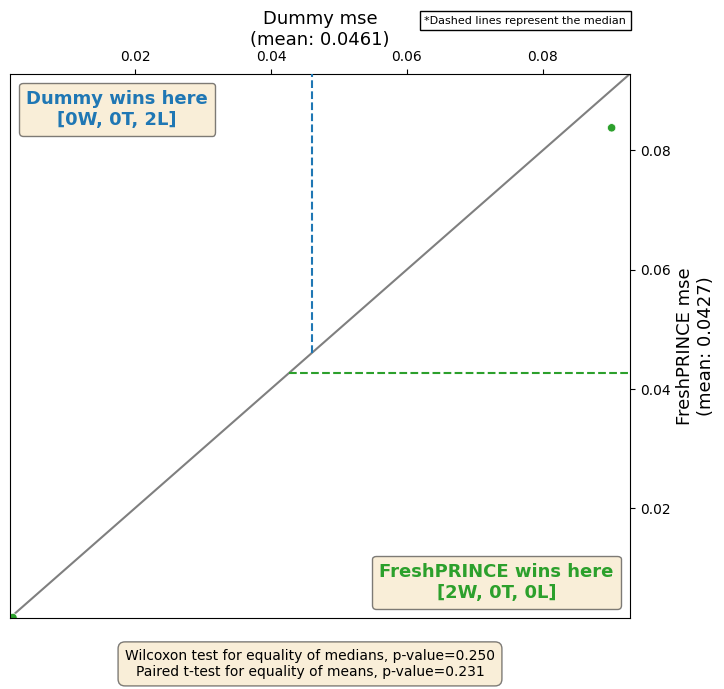

In [22]:
from aeon.visualisation import plot_pairwise_scatter

fig, ax = plot_pairwise_scatter(
    all_results[:, 1],
    all_results[:, 2],
    "FreshPRINCE",
    "Dummy",
    metric="mse",
    lower_better=True,
)


### Comparing multiple regressors

We can plot the results of multiple regressors on a critical difference diagram,
which shows the average rank and groups estimators by whether they are significantly
different from each other.

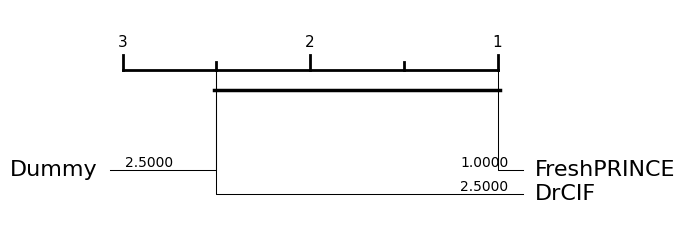

In [23]:
from aeon.visualisation import plot_critical_difference

res = plot_critical_difference(
    all_results,
    regressors,
    lower_better=True,
)

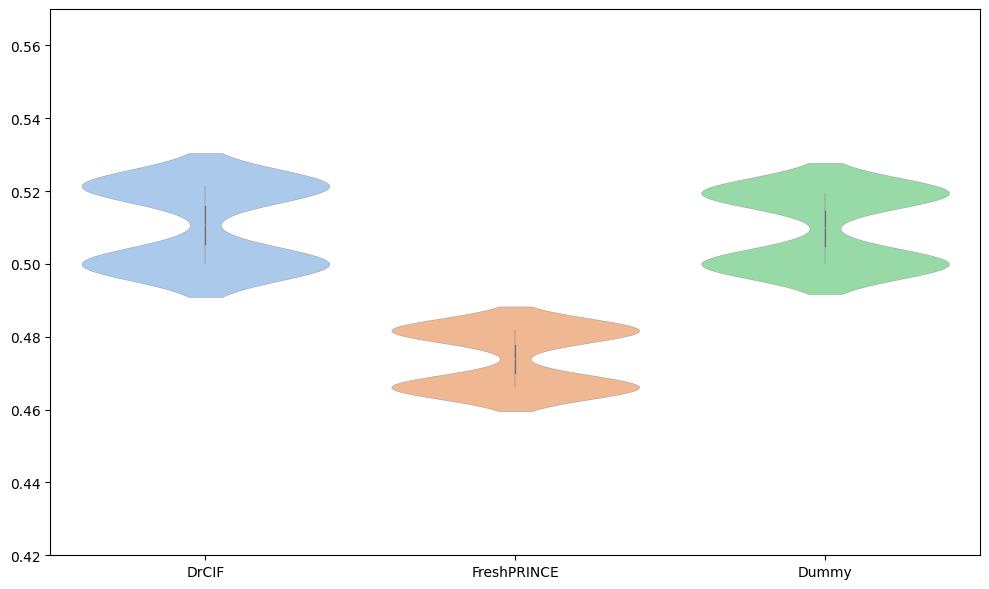

In [24]:
from aeon.visualisation import plot_boxplot

res = plot_boxplot(
    all_results,
    regressors,
    relative=True,
)